In [388]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn import preprocessing, linear_model, model_selection, metrics, datasets, base
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot
import xgboost as xgb
from sklearn.tree import _tree


In [2]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider



In [349]:
df=pd.read_csv(r'atp_data.csv')

In [350]:
df.head(10)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,1/3/2000,International,Outdoor,Hard,1st Round,3,Dosedel S.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Kiefer N.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Gaudio G.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
3,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,El Aynaoui Y.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
4,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Cherkasov A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
5,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Caratti C.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
6,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Berasategui A.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
7,3,Doha,Qatar Open,1/3/2000,International,Outdoor,Hard,1st Round,3,Bastl G.,...,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
8,2,Chennai,Gold Flake Open,1/3/2000,International,Outdoor,Hard,Semifinals,3,Hantschk M.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
9,2,Chennai,Gold Flake Open,1/3/2000,International,Outdoor,Hard,Semifinals,3,Golmard J.,...,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


Variables of interest

Target Variable: Upset-1 if a lower ranked player beats a higher ranked player, 0 otherwise

Categorical vars: ["Series","Court","Surface","Round","Tournament",'Comment']

Numerical vars: ['WRank','LRank','Wsets','Lsets','Year','elo_rank']

Calculated numerical vars: 


In [351]:
#Rank_Delta=Winner Rank- Loser Rank so if Delta>0, that means the winner has a higher numerical rank and the match is an upset
def upset(row):
    if row['Rank_Delta']>0:
        return 1
    else:
        return 0

In [352]:
def clean_data(df):
    df = df.sort_values("Date")
    df["WRank"] = df["WRank"].replace(np.nan, 0)
    df["WRank"] = df["WRank"].replace("NR", 2000)
    df["LRank"] = df["LRank"].replace(np.nan, 0)
    df["LRank"] = df["LRank"].replace("NR", 2000)
    df["WRank"] = df["WRank"].astype(int)
    df["LRank"] = df["LRank"].astype(int)
    df["Wsets"] = df["Wsets"].astype(float)
    df['Wsets'] = df['Wsets'].replace(np.nan, 0.0)
    df["Lsets"] = df["Lsets"].replace("`1", 1)
    df["Lsets"] = df["Lsets"].astype(float)
    df['Lsets'] = df['Lsets'].replace(np.nan, 0.0)
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(str(x), '%m/%d/%Y'))
    df['Year'] = df['Date'].apply(lambda x: x.year)
    # new var: Rank_Delta
    df['Rank_Delta'] = df['WRank'] - df['LRank']
    df = df.sort_values("Date")
    df.reset_index(drop=True, inplace=True)
    return df

In [353]:
def make_confusion_matrix(model, x_test, y_test, class_labels,threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(x_test)[:, 1] >= threshold)
    c_matrix = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(c_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=class_labels,
           yticklabels=class_labels);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    return plt

In [355]:
def plot_roc(model, x_test, y_test):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(x_test))
    plt.plot(fpr, tpr,lw=2)
    #plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve');
    print("ROC AUC score = ", metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))
    return plt

In [398]:
def generate_coef_table(feature_names, model, model_type, top_x_features):
    coef_table = pd.DataFrame(list(feature_names),columns=['Variable']).copy()
    if model_type=='regression':
        feature_scores=model.coef_.transpose()

    elif model_type=='tree':
        feature_scores=model.feature_importances_

    coef_table.insert(len(coef_table.columns),"Coefs",feature_scores)
    coefficient_table= pd.concat([coef_table.sort_values('Coefs', ascending=False)[:int(top_x_features/2)], coef_table.sort_values('Coefs', ascending=False)[-int(top_x_features/2):]])
    
    
    forest_importances = pd.Series(list(coefficient_table['Coefs'][:5]), index=list(coefficient_table['Variable'][:5]))
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Variables")
    ax.set_ylabel("Feature importances")
    fig.tight_layout() 

    return coefficient_table, fig

In [354]:
def final_comparison(models, x_test, y_test):
    scores=pd.DataFrame()
    for model in models:
        predictions = (model.predict(x_test))
        accuracy=metrics.accuracy_score(y_test,predictions)
        precision=metrics.precision_score(y_test,predictions)
        recall=metrics.recall_score(y_test,predictions)
        roc=roc_auc_score(y_test, predictions)
        scores[str(model)]=[accuracy,precision,recall, roc]
    scores.index=['accuracy','precision','recall','roc']
    return scores

In [357]:
df=clean_data(df)
df['upset']=df.apply(lambda row: upset(row),axis=1)
target_var=df['upset']
cat_vars = ["Series","Court","Surface","Round","Tournament",'Comment']
cat_features=pd.get_dummies(df[cat_vars], drop_first=True)
numeric_vars=['Wsets','Lsets','Year','elo_winner','elo_loser']
numeric_features=df[numeric_vars]
all_features=pd.concat([numeric_features,cat_features],1)

C:\Users\emwang\AppData\Local\Temp/ipykernel_30560/2393790483.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  all_features=pd.concat([numeric_features,cat_features],1)


In [217]:
X_train, X_test, y_train, y_test = train_test_split(all_features, target_var, test_size=0.20, random_state=42)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=list(X_train.columns))
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=list(X_train.columns))

In [123]:
print('Percent Upsets: {a}'.format(a=len(df[df['upset']==1])/len(df)))
print('Percent Expected: {a}'.format(a=len(df[df['upset']==0])/len(df)))

Percent Upsets: 0.3439205511317885
Percent Expected: 0.6560794488682115


In [391]:
lr = LogisticRegression(solver='liblinear', penalty = 'l2',random_state=42)
lr.fit(X_train_scaled, y_train)
predictions=lr.predict(X_test_scaled)
score=metrics.accuracy_score(y_test,predictions)
precision=metrics.precision_score(y_test,predictions)
recall=metrics.recall_score(y_test,predictions)

print(f1_score(lr.predict(X_test_scaled), y_test))
print(roc_auc_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.7236197872699645
0.7868159842883223
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      5824
           1       0.76      0.69      0.72      3118

    accuracy                           0.82      8942
   macro avg       0.80      0.79      0.79      8942
weighted avg       0.81      0.82      0.81      8942



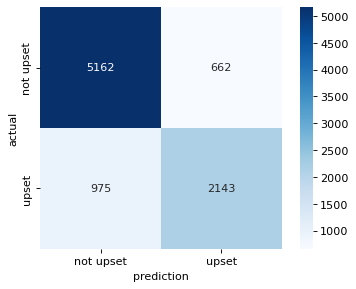

In [224]:
cm_plt=make_confusion_matrix(lr, X_test_scaled, y_test,class_labels=['not upset','upset'])
cm_plt.show()

ROC AUC score =  0.8929205265949574


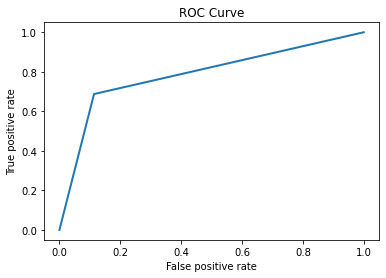

In [231]:
roc_curve=plot_roc(lr, X_test_scaled, y_test)
roc_curve.show()

In [239]:
from sklearn import tree
import graphviz 
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


### Winning Decision Tree Model

In [369]:
clf = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth=50, max_leaf_nodes= 1000, min_impurity_decrease=0.01, random_state=65)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
print(classification_report(y_test, predictions))
print('ROC: {a}'.format(a=roc_auc_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86      5824
           1       0.76      0.64      0.70      3118

    accuracy                           0.80      8942
   macro avg       0.79      0.77      0.78      8942
weighted avg       0.80      0.80      0.80      8942

ROC: 0.7662657759975753


In [371]:
clf_df=generate_coef_table(X_train.columns, clf, 'tree', 6)
clf_df

,Variable,Coefs
4,elo_loser,0.518618
3,elo_winner,0.481382
0,Wsets,0.000000
84,Tournament_Ecuador Open,0.000000
85,Tournament_Energis Open,0.000000
231,Comment_Walkover,0.000000


In [375]:
plt.figure(figsize=(50,30))
tree.plot_tree(clf,
               feature_names=list(X_train.columns),
               class_names=['not upset','upset'],
               fontsize=14)
plt.show()

TypeError: 'Figure' object is not callable

In [179]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': 11,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [302]:
rf = RandomForestClassifier(class_weight= {0: 1, 1: 2}, max_features= None, n_estimators= 900)
rf.fit(X_train,y_train)
predictions=rf.predict(X_test)
print(classification_report(y_test, predictions))
print("ROC score: {a}".format(a= roc_auc_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5824
           1       0.74      0.73      0.73      3118

    accuracy                           0.81      8942
   macro avg       0.80      0.79      0.80      8942
weighted avg       0.81      0.81      0.81      8942

ROC score: 0.794303856022105


In [ ]:
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, predictions))
score=metrics.accuracy_score(y_test,predictions)
precision=metrics.precision_score(y_test,predictions)
recall=metrics.recall_score(y_test,predictions)
print(recall)

In [305]:
df=generate_coef_table(X_train.columns, rf, 'tree', 20)
df.to_csv('rf_coefficients.csv')

C:\Users\emwang\AppData\Local\Temp/ipykernel_30560/2698978825.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


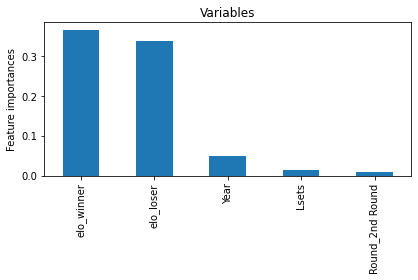

In [343]:
df, bar_graph=generate_coef_table(X_train.columns, rf, 'tree', 10)
bar_graph.show()

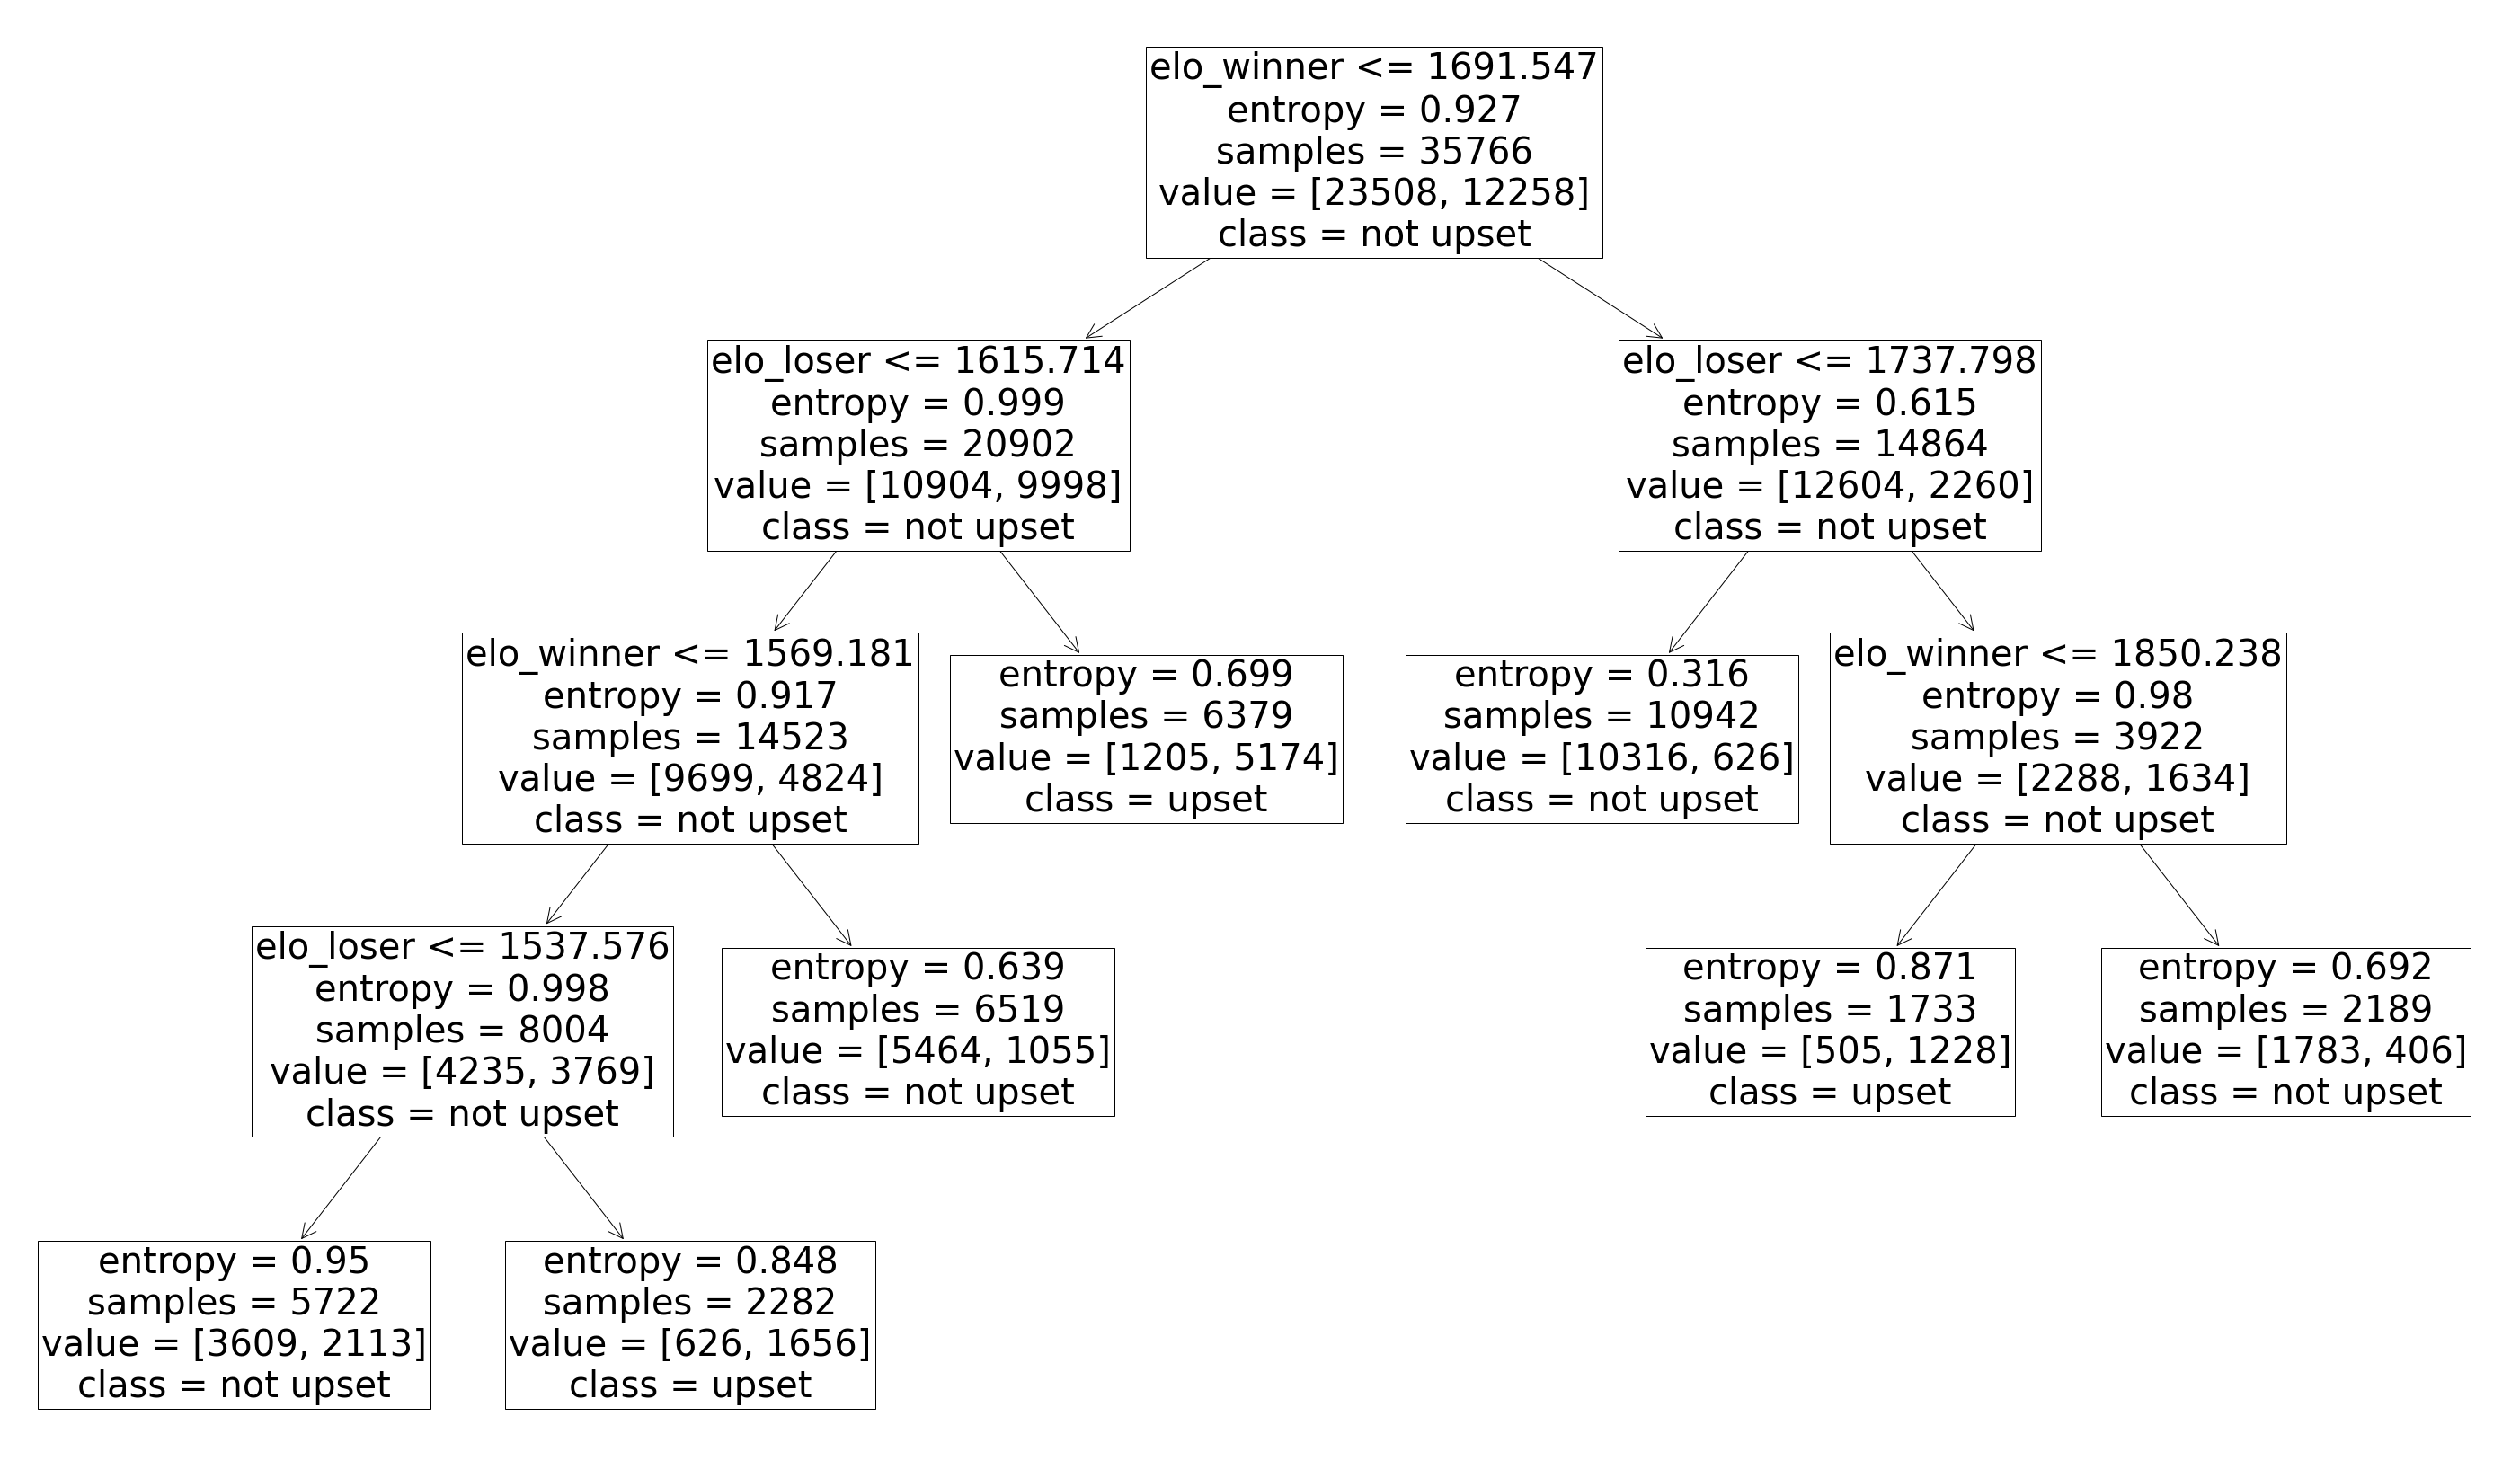

In [390]:
plt.figure(figsize=(50,30)) 
tree.plot_tree(clf,
               feature_names=list(X_train.columns),
               class_names=['not upset','upset'],
               fontsize=40)
plt.show()

In [297]:
from sklearn.ensemble import RandomForestClassifier

### Winning Random Forest Tree Model

In [396]:
rf = RandomForestClassifier(class_weight= {0: 1, 1: 2}, max_features= None, n_estimators= 900, random_state=65)
rf.fit(X_train,y_train)
rf_predictions=rf.predict(X_test)

In [397]:
print(f1_score(rf_predictions, y_test))
print(roc_auc_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

0.7337201805286913
0.7954377145465182
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5824
           1       0.74      0.73      0.73      3118

    accuracy                           0.82      8942
   macro avg       0.80      0.80      0.80      8942
weighted avg       0.81      0.82      0.82      8942



                              Variable     Coefs
3                           elo_winner  0.366049
4                            elo_loser  0.336973
2                                 Year  0.047603
1                                Lsets  0.014549
16                     Round_2nd Round  0.009947
128               Tournament_Lyon Open  0.000050
166           Tournament_Portugal Open  0.000049
178              Tournament_Ricoh Open  0.000035
95   Tournament_Gazprom Hungarian Open  0.000031
229               Comment_Disqualified  0.000010


C:\Users\emwang\AppData\Local\Temp/ipykernel_30560/1490828082.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


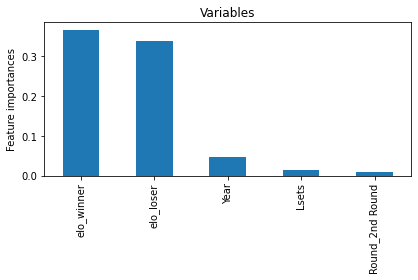

In [399]:
rf_df, plt=generate_coef_table(X_train.columns, rf, 'tree', 10)
print(rf_df)
plt.show()

### Winning XGBoost Model

In [402]:
xgb_model = xgb.XGBClassifier(random_state = 89
            ,colsample_bytree=0.5
            ,eta= 0.0
            ,max_depth=10
            ,n_estimators= 1000
            ,subsample= 1
         )
xgb_model.fit(X_train,y_train)
predictions=rf.predict(X_test)

In [403]:
print(f1_score(predictions, y_test))
print(roc_auc_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.7337201805286913
0.7954377145465182
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      5824
           1       0.74      0.73      0.73      3118

    accuracy                           0.82      8942
   macro avg       0.80      0.80      0.80      8942
weighted avg       0.81      0.82      0.82      8942



--------------END--------------

In [293]:
# def get_rules(tree, feature_names, class_names):
#     tree_ = tree.tree_
#     feature_name = [
#         feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
#         for i in tree_.feature
#     ]

#     paths = []
#     path = []
    
#     def recurse(node, path, paths):
        
#         if tree_.feature[node] != _tree.TREE_UNDEFINED:
#             name = feature_name[node]
#             threshold = tree_.threshold[node]
#             p1, p2 = list(path), list(path)
#             p1 += [f"({name} <= {np.round(threshold, 3)})"]
#             recurse(tree_.children_left[node], p1, paths)
#             p2 += [f"({name} > {np.round(threshold, 3)})"]
#             recurse(tree_.children_right[node], p2, paths)
#         else:
#             path += [(tree_.value[node], tree_.n_node_samples[node])]
#             paths += [path]
            
#     recurse(0, path, paths)

#     # sort by samples count
#     samples_count = [p[-1][1] for p in paths]
#     ii = list(np.argsort(samples_count))
#     paths = [paths[i] for i in reversed(ii)]
    
#     rules = []
#     for path in paths:
#         rule = "if "
        
#         for p in path[:-1]:
#             if rule != "if ":
#                 rule += " and "
#             rule += str(p)
#         rule += " then "
#         if class_names is None:
#             rule += "response: "+str(np.round(path[-1][0][0][0],3))
#         else:
#             classes = path[-1][0][0]
#             l = np.argmax(classes)
#             rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
#         rule += f" | based on {path[-1][1]:,} samples"
#         rules += [rule]
        
#     return rules

In [362]:
# rules = get_rules(clf, list(X_train.columns), ['not upset','upset'])
# for r in rules:
#     print(r)